In [1]:
import pandas as pd

df = pd.read_csv("appointments.csv")

In [4]:
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB
None


In [6]:
# Clean column names
df.columns = [col.strip().lower().replace('-', '_') for col in df.columns]

# Convert date columns to datetime
df['scheduledday'] = pd.to_datetime(df['scheduledday'])
df['appointmentday'] = pd.to_datetime(df['appointmentday'])

# Remove invalid ages
df = df[df['age'] >= 0]

# Convert 'no_show' to binary
df['no_show'] = df['no_show'].map({'No': 0, 'Yes': 1})

# Feature: Waiting days
df['waiting_days'] = (df['appointmentday'] - df['scheduledday']).dt.days
df = df[df['waiting_days'] >= 0]

# drop irrelevant columns
df.drop(['patientid', 'appointmentid'], axis=1, inplace=True)

<ipython-input-6-dcb64fd6e533>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['no_show'] = df['no_show'].map({'No': 0, 'Yes': 1})
<ipython-input-6-dcb64fd6e533>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['waiting_days'] = (df['appointmentday'] - df['scheduledday']).dt.days


no_show
0    0.71481
1    0.28519
Name: proportion, dtype: float64


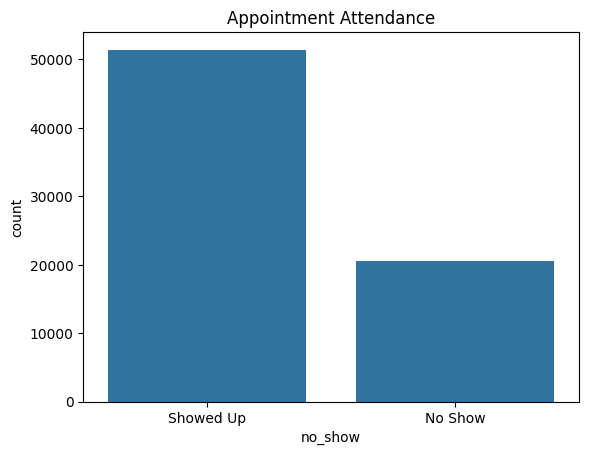

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# No-show rate
no_show_rate = df['no_show'].value_counts(normalize=True)
print(no_show_rate)

# Bar plot
sns.countplot(x='no_show', data=df)
plt.xticks([0, 1], ['Showed Up', 'No Show'])
plt.title('Appointment Attendance')
plt.show()

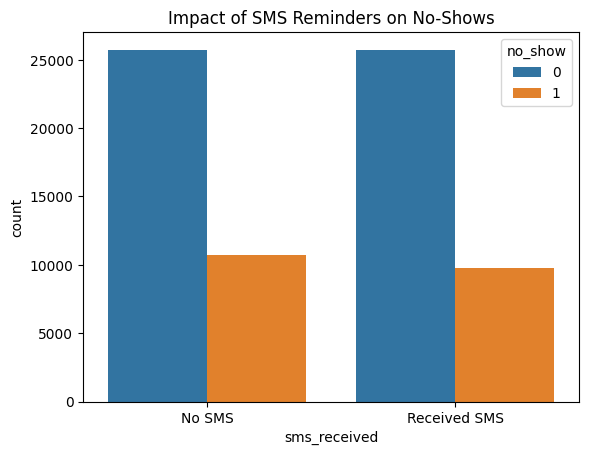

In [8]:
sns.countplot(x='sms_received', hue='no_show', data=df)
plt.xticks([0, 1], ['No SMS', 'Received SMS'])
plt.title('Impact of SMS Reminders on No-Shows')
plt.show()

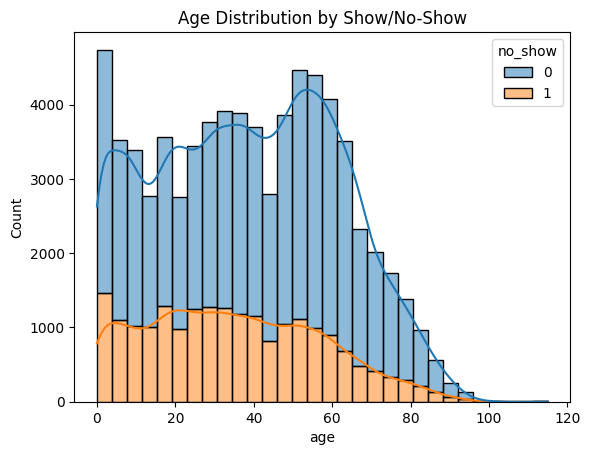

In [9]:
sns.histplot(data=df, x='age', hue='no_show', bins=30, kde=True, multiple='stack')
plt.title('Age Distribution by Show/No-Show')
plt.show()

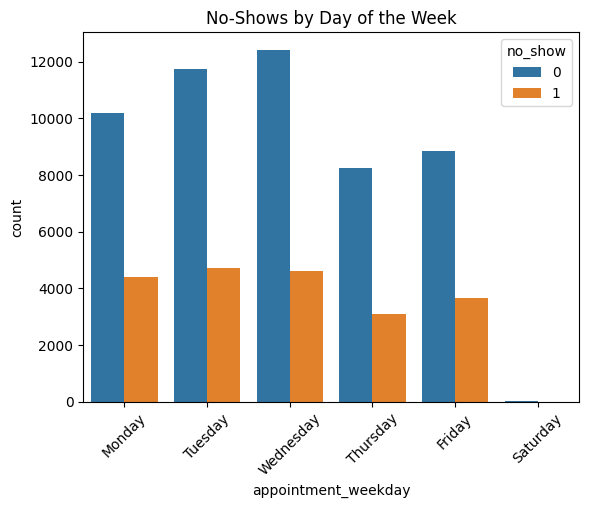

In [10]:
df['appointment_weekday'] = df['appointmentday'].dt.day_name()
sns.countplot(x='appointment_weekday', hue='no_show', data=df,
              order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
plt.title('No-Shows by Day of the Week')
plt.xticks(rotation=45)
plt.show()

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode categorical features
df['gender'] = LabelEncoder().fit_transform(df['gender'])
df['neighbourhood'] = LabelEncoder().fit_transform(df['neighbourhood'])
df['appointment_weekday'] = LabelEncoder().fit_transform(df['appointment_weekday'])

# Define features and target
X = df[['gender', 'age', 'scholarship', 'hipertension', 'diabetes',
        'alcoholism', 'handcap', 'sms_received', 'waiting_days',
        'neighbourhood', 'appointment_weekday']]

y = df['no_show']

In [12]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Initialize and train the model
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.617704280155642

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.72      0.73     10301
           1       0.34      0.35      0.34      4091

    accuracy                           0.62     14392
   macro avg       0.54      0.54      0.54     14392
weighted avg       0.62      0.62      0.62     14392


Confusion Matrix:
 [[7455 2846]
 [2656 1435]]


In [14]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize base model
dt = DecisionTreeClassifier(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid,
                           cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit on training data
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Evaluate best model
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

print("Tuned Model Accuracy:", accuracy_score(y_test, y_pred_best))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Tuned Model Accuracy: 0.7157448582545859

Classification Report:
               precision    recall  f1-score   support

           0       0.72      1.00      0.83     10301
           1       0.00      0.00      0.00      4091

    accuracy                           0.72     14392
   macro avg       0.36      0.50      0.42     14392
weighted avg       0.51      0.72      0.60     14392



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [15]:
# New patient data (must match feature order)
new_patient = pd.DataFrame([{
    'gender': 1,
    'age': 35,
    'scholarship': 0,
    'hipertension': 1,
    'diabetes': 0,
    'alcoholism': 0,
    'handcap': 0,
    'sms_received': 1,
    'waiting_days': 3,
    'neighbourhood': 56,
    'appointment_weekday': 2
}])

# Prediction
prediction = best_model.predict(new_patient)[0]

# Output
print("Prediction:", "No Show" if prediction == 1 else "Will Attend")


Prediction: Will Attend


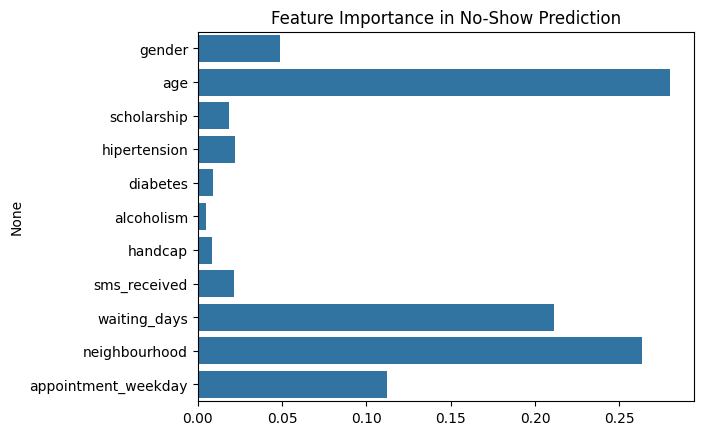

In [17]:
# Feature Importance Visualization
importances = clf.feature_importances_
features = X.columns
sns.barplot(x=importances, y=features)
plt.title('Feature Importance in No-Show Prediction')
plt.show()